In [1]:
import os
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt

from functools import reduce
from scipy.stats import randint, uniform
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_predict
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from boruta import BorutaPy
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from BorutaShap import BorutaShap
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, confusion_matrix, matthews_corrcoef, precision_recall_curve, average_precision_score
from sklearn.svm import SVC
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.datasets import make_classification
from lightgbm import LGBMClassifier
from sklearn.calibration import CalibratedClassifierCV

In [2]:
# Función para agregar métricas para cada modelo
# Recibe el nombre de la tabla que vas a imprimir, el nombre del modelo de al que se le realizarán los calculos,
# la variable objetivo, y la variable en la cual se almacenan las predicciones del modelo
def agregar_metricas(metricas, nombre_modelo, y_true, y_pred, y_proba):
    accuracy = accuracy_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    vpp = conf_matrix[1, 1] / (conf_matrix[0, 1] + conf_matrix[1, 1])
    vpn = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[1, 0])
    mcc = matthews_corrcoef(y_true, y_pred)
    # Calcular tasas de falsos positivos y verdaderos positivos para ROC-AUC
    fpr, tpr, thresholds_roc = roc_curve(y_true, y_proba[:, 1])
    auroc = auc(fpr, tpr)
    
    # Calcular la curva de precisión-recall y AUC para la curva AUPRC
    precision, recall, thresholds_pr = precision_recall_curve(y_true, y_proba[:, 1])
    auprc = auc(recall, precision) 
    
    metricas.loc[len(metricas)] = [nombre_modelo, accuracy, sensitivity, specificity, vpp, vpn, mcc, auroc, auprc]

In [3]:
# Read the CSV file
os.chdir("C:/Users/aleja/OneDrive/Escritorio/Alejandra/UCM/2023/Segundo Semestre/Tesis/Datos")

df = pd.read_csv("pimi.csv")

#antes de realizar este paso hay que revisar si la primera columna  contiene los indices de las filas
df = df.drop(df.columns[0], axis=1) #eliminar la primera columna
df

,X2000,X2005,X2010,X2015,X2020,X2025,X2030,X2035,X2040,X2045,...,X9950,X9955,X9965,X9970,X9975,X9980,X9985,X9990,X9995,objetivo
0,69012.81,0.00,216311.72,0.00,0.00,16107.16,33495.01,7686.08,20045.50,0.0,...,0.0,0.0,0.00,0.0,0.00,0.00,1777024.25,0.0,5.991136e+05,1
1,188707.49,56845.75,246625.85,34222.86,0.00,86770.47,0.00,106270.68,0.00,0.0,...,0.0,0.0,0.00,0.0,7298921.35,0.00,0.00,0.0,1.325792e+06,1
2,78341.42,0.00,223388.63,0.00,117680.17,158774.08,12963.32,0.00,16505.11,0.0,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.0,2.288813e+06,0
3,67135.91,0.00,67104.26,18216.68,0.00,17157.49,0.00,0.00,4875.75,0.0,...,0.0,0.0,0.00,0.0,0.00,1430113.47,0.00,0.0,6.582515e+05,1
4,66251.06,45434.77,206254.46,196166.34,62949.37,257334.05,101747.45,0.00,0.00,0.0,...,0.0,742729.3,0.00,0.0,0.00,0.00,8158185.91,0.0,1.890607e+06,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,0.00,0.00,313793.04,0.00,33025.35,0.00,0.00,2905144.22,0.00,64027.1,...,0.0,0.0,0.00,0.0,0.00,0.00,6258432.36,0.0,3.503717e+06,1
87,278150.10,0.00,0.00,0.00,22295.34,7300.83,767.94,16883.85,12070.22,0.0,...,0.0,0.0,0.00,0.0,0.00,0.00,4675884.02,0.0,1.462500e+06,1
88,291571.38,0.00,0.00,111025.43,0.00,0.00,0.00,60942.87,0.00,0.0,...,0.0,0.0,0.00,0.0,0.00,11612760.26,0.00,0.0,1.095409e+06,1
89,38233.93,0.00,73514.08,29569.76,0.00,0.00,49430.62,0.00,17718.72,0.0,...,0.0,0.0,0.00,0.0,0.00,876343.99,0.00,0.0,4.379777e+05,1


In [4]:
# Normalización del dataset
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Crea un objeto MinMaxScaler
scaler = MinMaxScaler()

# Aplica la normalización a las columnas numéricas
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

In [5]:
# Separating features and target variable
# Cambiar según el nombre de la variable objetivo correspondiente
X = df.drop(columns=['objetivo'])
Y = df['objetivo']

In [6]:
#Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# XGBoost

Boruta

In [7]:
# Crear un objeto clasificador XGBoost sin hiperparámetros específicos
#xgb_classifier = XGBClassifier()

# Convertir el DataFrame a un arreglo NumPy
#X_np = X.values
#Y_np = Y.values

# Crear un objeto Boruta con el clasificador XGBoost
#boruta_selector = BorutaPy(xgb_classifier, n_estimators='auto', verbose=2, random_state=42)

# Ajustar Boruta al conjunto de datos completo
#boruta_selector.fit(X_np, Y_np)

# Obtener características seleccionadas
#selected_features_xgb = X.columns[boruta_selector.support_].to_list()

# Imprimir las características seleccionadas
#print("Características seleccionadas por Boruta con XGBoost:")
#print(selected_features_xgb)

# Crear un objeto clasificador XGBoost utilizando solo características seleccionadas
#xgb_boruta = XGBClassifier()

# Aplicar XGBoost solo en características seleccionadas
#xgb_boruta.fit(X[selected_features_xgb], Y)

# Predecir en el conjunto completo
#y_pred_xgb_boruta = xgb_boruta.predict(X[selected_features_xgb])

Todos los atributos

In [8]:
# Crear un objeto clasificador XGBoost
xgb_all = xgb.XGBClassifier()

# Ajustar el modelo al conjunto de entrenamiento
xgb_all.fit(X_train, Y_train)

# Predecir en el conjunto de prueba
y_pred_xgb_all = xgb_all.predict(X_test)

# SVM

RFE

In [9]:
# Crear un clasificador LinearSVC
linear_svm = LinearSVC()

# Crear un objeto RFE con LinearSVC como estimador y el número deseado de características a seleccionar
num_features_to_select = 10  # Ajusta según tus necesidades
rfe_svm = RFE(estimator=linear_svm, n_features_to_select=num_features_to_select)

# Ajustar RFE al conjunto de datos completo
rfe_svm.fit(X, Y)

# Obtener las características seleccionadas por RFE
selected_features_rfe_svm = X.columns[rfe_svm.support_].to_list()
print("Características seleccionadas por RFE con LinearSVC:")
print(selected_features_rfe_svm)

# Crear un clasificador LinearSVC con los parámetros predeterminados
svm_selected_features = LinearSVC()

# Ajustar LinearSVC al conjunto completo con características seleccionadas
svm_selected_features.fit(X[selected_features_rfe_svm], Y)

# Predecir en el conjunto completo 
y_pred_svm_rfe = svm_selected_features.predict(X[selected_features_rfe_svm])

Características seleccionadas por RFE con LinearSVC:
['X2015', 'X3665', 'X5225', 'X5770', 'X5880', 'X7630', 'X8165', 'X8490', 'X9125', 'X9585']


Todos los atributos

In [10]:
# Crear un clasificador LinearSVC con los parámetros predeterminados
linear_svm = LinearSVC()

# Ajustar LinearSVC al conjunto de entrenamiento con todas las características
linear_svm.fit(X_train, Y_train)

# Predecir en el conjunto de prueba
y_pred_svm_all = linear_svm.predict(X_test)

# Random Forest

Boruta

In [11]:
# Crear un clasificador Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Convertir el DataFrame de pandas a un array de NumPy
X_np = X.values

# Crear un objeto Boruta con el clasificador Random Forest
boruta_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42)

# Ajustar Boruta al conjunto de datos completo
boruta_selector.fit(X_np, Y)

# Obtener características seleccionadas
selected_features = X.columns[boruta_selector.support_].to_list()
print("Características seleccionadas por Boruta:")
print(selected_features)

# Crear un clasificador Random Forest sin optimización de parámetros
rf_optimal = RandomForestClassifier(n_estimators=100, random_state=42)

# Ajustar Random Forest al conjunto completo con características seleccionadas por Boruta
rf_optimal.fit(X[selected_features], Y)

# Predecir en el conjunto completo
y_pred_rf_boruta = rf_optimal.predict(X[selected_features])

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	1134
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	1134
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	1134
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	1134
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	1134
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	1134
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	1134
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	1132
Iteration: 	9 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	1132
Iteration: 	10 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	1132
Iteration: 	11 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	1132
Iteration: 	12 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	1132
Iteration: 	13 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	1132
Iteration: 	14 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	1132
Iteration: 	15 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	1132
Iteration: 	16 / 100
Confirmed: 	0

RFE

In [12]:
# Crear un clasificador Random Forest
rf_rfe = RandomForestClassifier(n_estimators=100, random_state=42)

# Crear un objeto RFE con Random Forest como estimador y el número deseado de características a seleccionar
num_features_to_select = 10  # Ajusta según tus necesidades
rfe_rf = RFE(estimator=rf_rfe, n_features_to_select=num_features_to_select)

# Ajustar RFE al conjunto de datos completo
rfe_rf.fit(X, Y)

# Obtener características seleccionadas por RFE
selected_features_rfe = rfe_rf.support_

# Seleccionar las columnas correspondientes en el DataFrame
selected_columns = X.columns[selected_features_rfe]

# Imprimir las características seleccionadas
print("Características seleccionadas por RFE:")
print(selected_columns)

# Crear un clasificador Random Forest sin optimización de parámetros
rf_rfe_optimal = RandomForestClassifier(n_estimators=100, random_state=42)

# Ajustar Random Forest al conjunto completo con características seleccionadas por RFE
rf_rfe_optimal.fit(X[selected_columns], Y)

# Predecir en el conjunto completo
y_pred_rf_rfe = rf_rfe_optimal.predict(X[selected_columns])


Características seleccionadas por RFE:
Index(['X2000', 'X2030', 'X2445', 'X3315', 'X4845', 'X5205', 'X5225', 'X6045',
       'X7230', 'X9585'],
      dtype='object')


Todos los atributos

In [13]:
# Crear un clasificador Random Forest sin optimización de parámetros
rf_all = RandomForestClassifier(n_estimators=100, random_state=42)

# Ajustar Random Forest al conjunto completo con características seleccionadas por RFE
rf_all.fit(X_train, Y_train)

# Predecir en el conjunto completo
y_pred_rf_all = rf_all.predict(X_test)

XGB con RFE

In [14]:
# Crear un objeto RFE con XGBoost como estimador y el número deseado de características a seleccionar
num_features_to_select = 10  # Ajusta según tus necesidades
xgb_rfe_classifier = xgb.XGBClassifier()
rfe = RFE(estimator=xgb_rfe_classifier, n_features_to_select=num_features_to_select)

# Ajustar RFE al conjunto de datos completo
rfe.fit(X, Y)

# Obtener las características seleccionadas
selected_features_rfe = X.columns[rfe.support_].to_list()

# Imprimir las características seleccionadas
print("Características seleccionadas por RFE con XGBoost:")
print(selected_features_rfe)

# Crear un objeto clasificador XGBoost
xgb_rfe = xgb.XGBClassifier()

# Ajustar el modelo XGBoost solo a las características seleccionadas por RFE
xgb_rfe.fit(X[selected_features_rfe], Y)

# Predecir en el conjunto completo (o cualquier conjunto de datos que desees)
y_pred_xgb_rfe = xgb_rfe.predict(X[selected_features_rfe])

Características seleccionadas por RFE con XGBoost:
['X2035', 'X2470', 'X3290', 'X3610', 'X3660', 'X3975', 'X4845', 'X5210', 'X5380', 'X9780']


In [15]:
# Obtener las probabilidades del modelo XGB 
#y_proba_xgb_boruta = xgb_boruta.predict_proba(X[selected_features_xgb])
y_proba_xgb_rfe = xgb_rfe.predict_proba(X[selected_features_rfe])
y_proba_xgb_all = xgb_all.predict_proba(X_test)

# Obtener las probabilidades del modelo SVM
calibrated_svm = CalibratedClassifierCV(svm_selected_features, method='sigmoid', cv='prefit')
calibrated_svm.fit(X[selected_features_rfe_svm], Y)
y_prob_svm_rfe = calibrated_svm.predict_proba(X[selected_features_rfe_svm])

calibrated_svm_all = CalibratedClassifierCV(linear_svm, method='sigmoid', cv='prefit')
calibrated_svm_all.fit(X_train, Y_train)
y_prob_svm_all = calibrated_svm_all.predict_proba(X_test)

# Obtener las probabilidades del modelo Random Forest
y_proba_rf_boruta = rf_optimal.predict_proba(X[selected_features])
y_proba_rf_rfe = rf_rfe_optimal.predict_proba(X[selected_columns])
y_proba_rf_all = rf_all.predict_proba(X_test)

#Matrices de confusión

#XGB

#conf_matrix_xgb_boruta = confusion_matrix(Y, y_pred_xgb_boruta)
#print("XGB con Boruta:")
#print(conf_matrix_xgb_boruta)

conf_matrix_xgb_rfe = confusion_matrix(Y, y_pred_xgb_rfe)
print("\nXGB con RFE:")
print(conf_matrix_xgb_rfe)

conf_matrix_xgb_all = confusion_matrix(Y_test, y_pred_xgb_all)
print("\nXGB todos los atributos:")
print(conf_matrix_xgb_all)

#SVM

conf_matrix_svm_rfe = confusion_matrix(Y, y_pred_svm_rfe)
print("\nSVM con RFE:")
print(conf_matrix_svm_rfe)

# Establecer un umbral para la clasificación binaria
umbral = 0.5  # Puedes ajustar este valor según tus necesidades

# Convertir probabilidades en etiquetas binarias
y_pred_svm_all_binario = (y_pred_svm_all > umbral).astype(int)

# Calcular la matriz de confusión para las etiquetas binarias
conf_matrix_svm_all = confusion_matrix(Y_test, y_pred_svm_all_binario)

# Imprimir la matriz de confusión
print("\nSVM con todos los atributos:")
print(conf_matrix_svm_all)

#RF

conf_matrix_rf_boruta = confusion_matrix(Y, y_pred_rf_boruta)
print("\nRF con Boruta:")
print(conf_matrix_rf_boruta)

conf_matrix_rf_rfe = confusion_matrix(Y, y_pred_rf_rfe)
print("\nRF con RFE:")
print(conf_matrix_rf_rfe)

conf_matrix_rf_all = confusion_matrix(Y_test, y_pred_rf_all)
print("\nRF con todos los atributos:")
print(conf_matrix_rf_all)

# Calcular métricas

# Crear un DataFrame para almacenar las métricas
metricas = pd.DataFrame(columns=['Modelo', 'Precisión', 'Sensibilidad', 'Especificidad', 'VPP', 'VPN', 'MCC', 'AUROC', 'AUPCR'])
# Supongamos que tienes un modelo llamado "svm_selected_features" y predicciones "y_pred_svm"
#agregar_metricas(metricas, 'XGB con Boruta', Y, y_pred_xgb_boruta, y_proba_xgb_boruta)
agregar_metricas(metricas, 'XGB con RFE', Y, y_pred_xgb_rfe, y_proba_xgb_rfe)
agregar_metricas(metricas, 'XGB all', Y_test, y_pred_xgb_all, y_proba_xgb_all)
agregar_metricas(metricas, 'SVM con RFE', Y, y_pred_svm_rfe, y_prob_svm_rfe)
agregar_metricas(metricas, 'SVM all', Y_test, y_pred_svm_all_binario, y_prob_svm_all)
agregar_metricas(metricas, 'RF con Boruta', Y, y_pred_rf_boruta, y_proba_rf_boruta)
agregar_metricas(metricas, 'RF con RFE', Y, y_pred_rf_rfe, y_proba_rf_rfe)
agregar_metricas(metricas, 'RF all', Y_test, y_pred_rf_all, y_proba_rf_all)
metricas


XGB con RFE:
[[28  2]
 [ 1 60]]

XGB todos los atributos:
[[ 1  6]
 [ 1 11]]

SVM con RFE:
[[22  8]
 [ 1 60]]

SVM con todos los atributos:
[[ 1  6]
 [ 0 12]]

RF con Boruta:
[[18 12]
 [ 0 61]]

RF con RFE:
[[30  0]
 [ 0 61]]

RF con todos los atributos:
[[ 0  7]
 [ 0 12]]


,Modelo,Precisión,Sensibilidad,Especificidad,VPP,VPN,MCC,AUROC,AUPCR
0,XGB con RFE,0.967033,0.983607,0.933333,0.967742,0.965517,0.925064,0.997541,0.998844
1,XGB all,0.631579,0.916667,0.142857,0.647059,0.500000,0.093560,0.547619,0.614757
2,SVM con RFE,0.901099,0.983607,0.733333,0.882353,0.956522,0.775514,0.945902,0.970394
3,SVM all,0.684211,1.000000,0.142857,0.666667,1.000000,0.308607,0.738095,0.715795
4,RF con Boruta,0.868132,1.000000,0.600000,0.835616,1.000000,0.708075,0.868852,0.943297
5,RF con RFE,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
6,RF all,0.631579,1.000000,0.000000,0.631579,NaN,0.000000,0.630952,0.781286


In [16]:
# Definir el espacio de búsqueda para los hiperparámetros
param_space_rf_rfe = {
    'n_estimators': Integer(50, 300),
    'max_depth': Integer(5, 100),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 10),
    'max_features': Real(0.1, 1.0),  # Agregado para controlar el número de características consideradas en cada split
    'bootstrap': Categorical([True, False]),  # Agregado para permitir el muestreo con reemplazo o sin reemplazo
}

# Inicializar la búsqueda bayesiana con el clasificador y el espacio de búsqueda
optimal_rf_rfe = BayesSearchCV(
    RandomForestClassifier(),
    param_space_rf_rfe,
    n_iter=50,
    random_state=42,
    n_jobs=-1,
    cv=10
)

# Realizar la búsqueda bayesiana en validación cruzada
optimal_rf_rfe.fit(X[selected_columns], Y)

# Imprimir los hiperparámetros óptimos encontrados
print("Hiperparámetros óptimos para Random Forest con RFE:", optimal_rf_rfe.best_params_)

# Crear un clasificador Random Forest con los hiperparámetros óptimos
rf_rfe_optimal = RandomForestClassifier(**optimal_rf_rfe.best_params_, random_state=42)

# Ajustar Random Forest al conjunto completo con características seleccionadas por RFE y optimización bayesiana
rf_rfe_optimal.fit(X[selected_columns], Y)

# Predecir en el conjunto completo
y_pred_rf_rfe_opt = rf_rfe_optimal.predict(X[selected_columns])

Hiperparámetros óptimos para Random Forest con RFE: OrderedDict([('bootstrap', True), ('max_depth', 100), ('max_features', 1.0), ('min_samples_leaf', 2), ('min_samples_split', 20), ('n_estimators', 300)])


In [17]:
# Calcular métricas
y_proba_rf_rfe_opt = rf_rfe_optimal.predict_proba(X[selected_columns])
conf_matrix_rf_rfe_opt = confusion_matrix(Y, y_pred_rf_rfe_opt)

# Imprimir métricas
print("Matriz de confusión optimizada:")
print(conf_matrix_rf_rfe_opt)

# Crear un DataFrame para almacenar las métricas
metricas_rf_opt = pd.DataFrame(columns=['Modelo', 'Precisión', 'Sensibilidad', 'Especificidad', 'VPP', 'VPN', 'MCC', 'AUROC', 'AUPCR'])
# Supongamos que tienes un modelo llamado "svm_selected_features" y predicciones "y_pred_svm"
agregar_metricas(metricas_rf_opt, 'RF con RFE opt', Y, y_pred_rf_rfe_opt, y_proba_rf_rfe_opt)
metricas_rf_opt

Matriz de confusión optimizada:
[[25  5]
 [ 4 57]]


,Modelo,Precisión,Sensibilidad,Especificidad,VPP,VPN,MCC,AUROC,AUPCR
0,RF con RFE opt,0.901099,0.934426,0.833333,0.919355,0.862069,0.774562,0.962295,0.980675


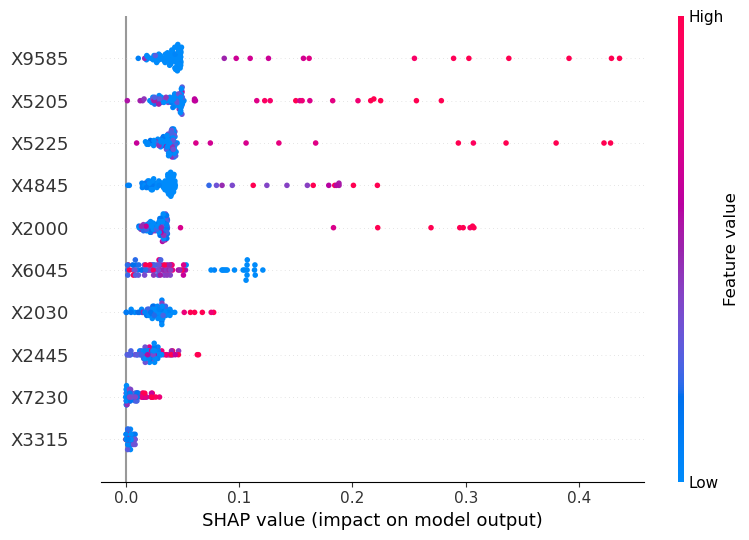

In [18]:
# Crear un explainer de SHAP para el modelo XGBoost con características seleccionadas por RFE
explainer_rf = shap.TreeExplainer(rf_rfe_optimal)

# Obtener los SHAP values para el conjunto de prueba (ajusta según tus necesidades)
shap_values_rf = explainer_rf.shap_values(X[selected_columns])

# Calcular el valor SHAP promedio para cada observación y característica
average_shap_values_rf = np.mean(np.abs(shap_values_rf), axis=0)

# Graficar el resumen de SHAP values
shap.summary_plot(average_shap_values_rf, X[selected_columns], plot_type="dot", show=False)

In [19]:
# Filtrar las columnas marcadas con '*' y agregar la columna 'objetivo'
data_final = pd.DataFrame()

data_final = df[selected_columns]

# Agregar la columna 'objetivo'
data_final['objetivo'] = df['objetivo']

In [20]:
data_final

,X2000,X2030,X2445,X3315,X4845,X5205,X5225,X6045,X7230,X9585,objetivo
0,0.025904,0.017021,0.005385,0.026864,0.000000,0.159399,0.000000,0.216701,0.284303,0.332893,1.0
1,0.070831,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
2,0.029405,0.006587,0.029828,0.081395,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,0.025199,0.000000,0.000000,0.008137,0.000000,0.119859,0.097740,0.152619,0.147017,0.000000,1.0
4,0.024867,0.051704,0.055301,0.234123,0.050328,0.148050,0.167169,0.381809,0.287319,0.333653,0.0
...,...,...,...,...,...,...,...,...,...,...,...
86,0.000000,0.000000,0.000340,0.000000,0.000000,0.000000,0.249390,0.362104,0.000000,0.000000,1.0
87,0.104403,0.000390,0.003099,0.010961,0.000000,0.116944,0.105470,0.166514,0.171764,0.000000,1.0
88,0.109441,0.000000,0.000000,0.000000,0.000000,0.134721,0.000000,0.361196,0.235354,0.000000,1.0
89,0.014351,0.025119,0.008061,0.029306,0.000000,0.254180,0.233385,0.177649,0.228588,0.000000,1.0


In [21]:
# Especificar la dirección donde quieres guardar el archivo CSV (sustituye 'ruta/del/archivo.csv' por tu ruta)
csv = '/Users/aleja/OneDrive/Escritorio/Alejandra/UCM/2023/Segundo Semestre/Tesis/Datos/pimiopt.csv'

# Guardar el DataFrame en un archivo CSV
data_final.to_csv(csv, index=False)